In [26]:
import trimesh as tm
from halfedge_mesh.halfedge_mesh import *
import numpy as np
import meshplot as mp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import igl
import open3d as o3d
from scipy.sparse import csr_matrix, eye 
from scipy.sparse.linalg import eigs, spsolve



In [27]:
plane = tm.load("meshes/curvatures/plane.obj")
lilium_s = tm.load("meshes/curvatures/lilium_s.obj")
fandisk_ns = tm.load("meshes/smoothing/fandisk_ns.obj")
plane_ns = tm.load("meshes/smoothing/plane_ns.obj")
armadillo = tm.load("meshes/decomposition/armadillo.obj")
camel = tm.load("meshes/camel.obj")
bunny = tm.load("meshes/bunny.obj")

## Task 1

In [28]:

def Mean_Curvature(mesh):
    vertices = mesh.vertices
    vertices_centered = vertices - np.mean(vertices, axis=0)
    
    A = np.eye(len(vertices))
    
    for i, neighbors in enumerate(mesh.vertex_neighbors):
        for neighbor in neighbors:
            A[i, neighbor] = -1 / len(neighbors)
    
    # Apply the Laplacian matrix to the vertices
    result = np.dot(A, vertices_centered)
    
    # Calculate the mean curvature
    H = np.linalg.norm(result, axis=1) / 2
    
    
    return H


In [ ]:
mean_curvature = Mean_Curvature(lilium_s)
mp.plot(lilium_s.vertices, lilium_s.faces, mean_curvature)

In [30]:

def compute_vertex_area(mesh):
    faces_area = mesh.area_faces
    faces = mesh.faces
    
    A = np.zeros(len(mesh.vertices))

    # Iterate over each face once
    for face_idx, face in enumerate(faces):
        for vertex_idx in face:
            A[vertex_idx] += faces_area[face_idx] / 3
    
    return A


def Gauss_curvature(mesh):

    thetas = np.zeros((mesh.vertices.shape[0],))

    for face, angles in zip(mesh.faces, mesh.face_angles):
        # Accumulate the angles
        thetas[face] += angles
    A = compute_vertex_area(mesh)
    K = (2 * np.pi - thetas)/A
    K =( K - np.min(K))/( np.max(K) - np.min(K))

    return K
    

In [31]:
K = Gauss_curvature(lilium_s)
mp.plot(lilium_s.vertices, lilium_s.faces, K)
print(lilium_s.area_faces.shape)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.367806…

(1500,)


### Task 2

In [32]:
def first_ellipsoid(u,v):
    #define a,b,c
    a = 1
    b = 2
    c = 3

    x_u = np.array([
        -a * np.sin(u) * np.sin(v),
        b * np.cos(u) * np.sin(v),
        0
    ])
    x_v = np.array([
        a * np.cos(u) * np.cos(v),
        b * np.sin(u) * np.cos(v),
        -c * np.sin(v)
    ])

    I = np.array([[x_u.T @ x_u, x_u.T @ x_v], [x_u.T @ x_v, x_v.T @ x_v]])

    return x_u, x_v, I

def second_ellipsoid(u,v):
    #define a,b,c
    a = 1
    b = 2
    c = 3

    x_uu = np.array([
        -a * np.cos(u) * np.sin(v),
        -b * np.sin(u) * np.sin(v),
        0
    ])
    x_uv = np.array([
        -a * np.sin(u) * np.cos(v),
        b * np.cos(u) * np.cos(v),
        0
    ])
    x_vv = np.array([
        -a * np.cos(u) * np.sin(v),
        -b * np.sin(u) * np.sin(v),
        -c * np.cos(v)
    ])

    x_u, x_v, _ = first_ellipsoid(u,v)

    normal = np.cross(x_u, x_v)
    normal /= np.linalg.norm(normal)

    II = np.array([[x_uu.T @ normal, x_uv.T @ normal], [x_uv.T @ normal, x_vv @ normal]])



    return x_uu, x_uv, x_vv, II

In [33]:
def cal_norm_culvature(t_bar):
    # u, v at point (a, 0, 0)
    u = 0
    v = np.pi / 2.

    _, _, I = first_ellipsoid(u, v)
    _, _, _, II = second_ellipsoid(u, v)

    k_n = (t_bar.T @ II @ t_bar)/ (t_bar.T @ I @ t_bar)

    return k_n

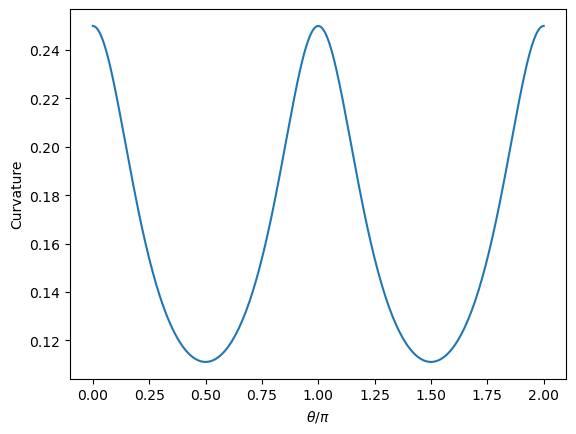

In [41]:
import matplotlib.pyplot as plt

angle_values = np.linspace(0, 2 * np.pi, 2**8 + 1)

curvature_values = [
    cal_norm_culvature(np.array([np.cos(angle), np.sin(angle)]).T)
    for angle in angle_values
]
plt.ylabel('Curvature')
plt.xlabel('$\\theta / \pi$')
plt.plot(angle_values / np.pi, curvature_values)
plt.show()

### Task3

In [35]:
def neighbor_neighbor(a, b, mesh):
    faces = np.array(mesh.faces)
    contains_a = np.any(faces == a, axis=1)
    contains_b = np.any(faces == b, axis=1)
    contains_both = contains_a & contains_b
    relevant_faces = faces[contains_both]
    neighbors = relevant_faces[np.logical_and(relevant_faces != a, relevant_faces != b)]
    unique_neighbors = np.unique(neighbors.flatten())
    if unique_neighbors.size == 2:
        return unique_neighbors[0], unique_neighbors[1]
    elif unique_neighbors.size == 1:
        return unique_neighbors[0], None
    else:
        return None, None

def cotangent_laplace_beltrami(mesh):
    n_vertices = len(mesh.vertices)
    row_indices = []
    col_indices = []
    data = []

    for i, neighbors in enumerate(mesh.vertex_neighbors):
        sum_cot = 0
        for neighbor in neighbors:
            n_f, n_b = neighbor_neighbor(i, neighbor, mesh)
            
            if n_f is not None:
                vi_nf = mesh.vertices[i] - mesh.vertices[n_f]
                vj_nf = mesh.vertices[neighbor] - mesh.vertices[n_f]
                cos_alpha = np.dot(vi_nf, vj_nf) / (np.linalg.norm(vi_nf) * np.linalg.norm(vj_nf))
                cot_alpha = 1 / np.tan(np.arccos(np.clip(cos_alpha, -1, 1)))
            else:
                cot_alpha = 0

            if n_b is not None:
                vi_nb = mesh.vertices[i] - mesh.vertices[n_b]
                vj_nb = mesh.vertices[neighbor] - mesh.vertices[n_b]
                cos_beta = np.dot(vi_nb, vj_nb) / (np.linalg.norm(vi_nb) * np.linalg.norm(vj_nb))
                cot_beta = 1 / np.tan(np.arccos(np.clip(cos_beta, -1, 1)))
            else:
                cot_beta = 0

            cot_weight = cot_alpha + cot_beta
            if cot_weight > 0:
                row_indices.append(i)
                col_indices.append(neighbor)
                data.append(cot_weight)
                sum_cot += cot_weight

        # Diagonal element
        row_indices.append(i)
        col_indices.append(i)
        data.append(-sum_cot)

    L = csr_matrix((data, (row_indices, col_indices)), shape=(n_vertices, n_vertices))

    return L


In [36]:
def mean_curvature_cot(mesh):
    A = compute_vertex_area(mesh)
    cot = cotangent_laplace_beltrami(mesh)
    A = A.astype(np.float64)
    print(A.shape, cot.shape)
    H = 0.5 * (1 / A[:,np.newaxis]) * (cot @ mesh.vertices)
    H_cot = np.linalg.norm(H, axis=1)

    return H_cot
    

In [12]:
mean_curv_cot = mean_curvature_cot(plane)
mp.plot(plane.vertices, plane.faces, mean_curv_cot)

(100,) (100, 100)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.150000…

### Task 4

In [13]:

def neighbor_neighbor(a, b, mesh):
    faces = np.array(mesh.faces)
    contains_a = np.any(faces == a, axis=1)
    contains_b = np.any(faces == b, axis=1)
    contains_both = contains_a & contains_b
    relevant_faces = faces[contains_both]
    neighbors = relevant_faces[np.logical_and(relevant_faces != a, relevant_faces != b)]
    unique_neighbors = np.unique(neighbors.flatten())
    if unique_neighbors.size == 2:
        return unique_neighbors[0], unique_neighbors[1]
    elif unique_neighbors.size == 1:
        return unique_neighbors[0], None
    else:
        return None, None

def cotangent_laplace_beltrami_cont(mesh):
    n_vertices = len(mesh.vertices)
    row_indices = []
    col_indices = []
    data = []
    A = compute_vertex_area(mesh)

    for i, neighbors in enumerate(mesh.vertex_neighbors):
        sum_cot = 0
        for neighbor in neighbors:
            n_f, n_b = neighbor_neighbor(i, neighbor, mesh)
            
            vi_nf = mesh.vertices[i] - mesh.vertices[n_f]
            vj_nf = mesh.vertices[neighbor] - mesh.vertices[n_f]
            cos_alpha = np.dot(vi_nf, vj_nf) / (np.linalg.norm(vi_nf) * np.linalg.norm(vj_nf))
            cot_alpha = 1 / np.tan(np.arccos(np.clip(cos_alpha, -1, 1)))

            vi_nb = mesh.vertices[i] - mesh.vertices[n_b]
            vj_nb = mesh.vertices[neighbor] - mesh.vertices[n_b]
            cos_beta = np.dot(vi_nb, vj_nb) / (np.linalg.norm(vi_nb) * np.linalg.norm(vj_nb))
            cot_beta = 1 / np.tan(np.arccos(np.clip(cos_beta, -1, 1)))

            cot_weight = cot_alpha + cot_beta
            if cot_weight > 0:
                area_sum = A[i] + A[neighbor]
                cot_weight /= area_sum
                row_indices.append(i)
                col_indices.append(neighbor)
                data.append(cot_weight)
                sum_cot += cot_weight

        # Diagonal element
        row_indices.append(i)
        col_indices.append(i)
        data.append(-sum_cot)

    L = csr_matrix((data, (row_indices, col_indices)), shape=(n_vertices, n_vertices))

    return L


In [14]:
    
def mesh_reconstruction(mesh, k):

    # Compute sparse Laplace-Beltrami matrix
    csr_L = cotangent_laplace_beltrami_cont(mesh)
    print(csr_L.shape)

    _, e = eigs(csr_L, k=k, which='SM')
    e = e.real

    smooth_mesh = mesh.copy()


    vertices = smooth_mesh.vertices
    smooth_vertices = np.zeros(smooth_mesh.vertices.shape)

    for channel in range(3):
        smooth_vertices[:,channel] = np.sum((vertices[:,channel].T @ e) * e, axis = 1)
    smooth_mesh.vertices = smooth_vertices
    
    return smooth_mesh



In [88]:
reconstructed_mesh = mesh_reconstruction(armadillo, 15)

(25193, 25193)


In [ ]:
o3d.io.write_triangle_mesh('reconstructed_armadillo_15.obj', reconstructed_mesh.as_open3d)

### Task 5

In [16]:

def uniform_laplace_beltrami(mesh):
    n_vertices = len(mesh.vertices)
    row_indices = []
    col_indices = []
    data = []

    for i, neighbors in enumerate(mesh.vertex_neighbors):
        n_neighbors = len(neighbors)
        if n_neighbors > 0:
            weight = 1.0 / n_neighbors  # Uniform weight

            for neighbor in neighbors:
                row_indices.append(i)
                col_indices.append(neighbor)
                data.append(weight)

            row_indices.append(i)
            col_indices.append(i)
            data.append(-1.0)  

    L = csr_matrix((data, (row_indices, col_indices)), shape=(n_vertices, n_vertices))

    return L


In [17]:
def explicit_mesh_smoothing(mesh, lamda, max_iter = 10):
    smoothed_mesh = mesh.copy()
    

    for i in range(max_iter):
        L = uniform_laplace_beltrami(smoothed_mesh)
        smoothed_mesh.vertices += lamda * L @ smoothed_mesh.vertices

    return smoothed_mesh

In [18]:
explicit_mesh = explicit_mesh_smoothing(fandisk_ns, 3)

igl.write_obj('task5/fandiskns_001.obj', explicit_mesh.vertices, explicit_mesh.faces)

True

### Task 6

In [59]:

def implicit_mesh_smoothing(mesh, lamda, max_iter = 10):
    smoothed_mesh = mesh.copy()
    
    # Number of vertices
    n_vertices = len(mesh.vertices)

    for i in range(max_iter):
        L = uniform_laplace_beltrami(smoothed_mesh)
        left = eye(n_vertices, format='csr') - lamda * L
        
        smoothed_mesh.vertices = spsolve(left, smoothed_mesh.vertices)

    return smoothed_mesh


In [56]:

def implicit_discrete_mesh_smoothing(mesh, lamda, max_iter = 10):
    smoothed_mesh = mesh.copy()
    n_vertices = len(mesh.vertices)

    for i in range(max_iter):
        L = cotangent_laplace_beltrami(smoothed_mesh)
        left = eye(n_vertices, format='csr') - lamda * L
        
        smoothed_mesh.vertices = spsolve(left, smoothed_mesh.vertices)

    return smoothed_mesh

In [64]:
implicit_mesh = implicit_mesh_smoothing(fandisk_ns, 0.1, max_iter=10)

igl.write_obj('task6/iter10.obj', implicit_mesh.vertices, implicit_mesh.faces)

True

### Task 7

In [21]:

def add_noise(mesh):
    
    magnitude = mesh.scale / 10.0

    random_noise = np.random.normal(0, magnitude, mesh.vertices.shape)
    
    noisy_mesh = mesh.copy()
    noisy_mesh.vertices += random_noise

    return noisy_mesh


In [40]:
noisy_fandisk = add_noise(fandisk_ns)

implicit_noisy_fandisk = implicit_discrete_mesh_smoothing(noisy_fandisk, 1)
igl.write_obj('task7/im_dis_fandisk_1_01.obj', implicit_noisy_fandisk.vertices, implicit_noisy_fandisk.faces)

True

In [22]:
noisy_fandisk = add_noise(fandisk_ns)

implicit_noisy_fandisk = implicit_mesh_smoothing(noisy_fandisk, 5)
explicit_noisy_fandisk = explicit_mesh_smoothing(noisy_fandisk, 1)
igl.write_obj('task7/ex_fandisk_1_0001.obj', explicit_noisy_fandisk.vertices, explicit_noisy_fandisk.faces)
igl.write_obj('task7/im_fandisk_5_01.obj', implicit_noisy_fandisk.vertices, implicit_noisy_fandisk.faces)

True